In [1]:
from neural_priors.utils.plotting import plot_prf_predictions
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr
from braincoder.models import LogGaussianPRF, GaussianPRF

In [2]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [3]:
bids_folder = '../../ds-neuralpriors'

In [4]:
behavior = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])

In [5]:
# from tqdm.contrib.itertools import product

In [6]:
load_data_via_tsv = True

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = [f'{subject:02d}' for subject in range(1, 11)]
    #subjects.pop(subjects.index('11'))
    #subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False], [False, True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)
        if gaussian:
            sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
        else:
            sub_df = sub_df.rename(columns={'fwhm':'width'})
        df.append(sub_df)
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed',
                    'gaussian' if gaussian else 'lognormal'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.droplevel('session', axis=0)
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

In [7]:
df

model                      gaussian                                                                                                                                 \
parameter                      mode                                      width                                amplitude                                   baseline   
range_n                        wide     narrow       both      wide2      wide     narrow      both     wide2      wide      narrow       both     wide2      wide   
subject smoothed   voxel                                                                                                                                             
01      smoothed   0      37.364826  21.124500  37.348385  11.517796  0.341002   0.396827  0.346775  0.906162  1.438429    0.680798   1.289311  0.729588 -0.130019   
                   1      33.824623   4.783791  33.821358  11.687057  0.691629   4.528500  0.667084  0.466805  0.748930    0.540905   0.723414  1.072110 -0.531615   
                   2      28.557991  11.896777  28.558237  15.473819  0.415108   0.934195  0.399016  1.315624  0.991627    0.328446   0.965211  0.488749 -0.533834   
                   3      15.576399  12.634756  15.078053  15.590551  1.232276   2.400554  1.203502  1.414796  0.484945    0.272006   0.293359  0.609456 -0.345589   
                   4      11.836634   8.140844  11.579211  11.840950  0.779714   0.545360  1.052765  0.820746  0.961715  153.636470   0.375336  1.067275 -0.108668   
...                             ...        ...        ...        ...       ...        ...       ...       ...       ...         ...        ...       ...       ...   
38      unsmoothed 697    12.484799   6.792138  10.311142  12.482238  0.664732   4.126427  2.428229  0.703325  0.524959    0.987310   0.462412  0.526505  0.018834   
                   698    34.230650  15.114270  34.231560  20.379576  1.057392   0.229958  1.006889  3.538527  0.692827    0.247191   0.666601  0.418633  0.015353   
                   699    30.159763  14.136518  30.157118  18.601698  0.622103   0.562273  0.629685  0.377287  0.687669    0.456858   0.692780  0.878269 -0.007069   
                   700    33.457390 -20.811913   5.260218  10.440446  0.410653  37.259600  1.755525  0.365949  1.304185    3.031507  29.586637  1.065640  0.127513   
                   701     9.317807   3.766264   7.819368   9.402459  1.831878  31.759820  4.203909  1.932335  0.695855    3.963244   0.577808  0.725357  0.019249   

model                                                                                                                                   lognormal                        \
parameter                                                     r2                                    cvr2                                     mode                         
range_n                     narrow      both     wide2      wide    narrow      both     wide2      wide    narrow      both     wide2       wide     narrow       both   
subject smoothed   voxel                                                                                                                                                  
01      smoothed   0     -0.100848 -0.096930 -0.242621  0.025210  0.020509  0.013219  0.031572 -0.010679 -0.037111 -0.013963 -0.150426  37.357880  21.101067  37.343750   
                   1     -0.537404 -0.504734 -0.641905  0.021125  0.009864  0.011212  0.036705 -0.077199 -0.060669 -0.033635 -0.112344  33.805150   4.180238  33.803192   
                   2     -0.502003 -0.494730 -0.664774  0.028490  0.019594  0.015095  0.043335 -0.078409 -0.051255 -0.040969 -0.139146  28.577208  11.842598  28.558933   
                   3     -0.334171 -0.312884 -0.462194  0.027097  0.027599  0.014951  0.070238 -0.079311 -0.021471 -0.060922 -0.090663  15.417795  12.327776  15.034226   
                   4     -0.120475 -0.110317 -0.199313  0.027147  0.013595  0.008204  0.050541 -0.054760 -0.026661 -0.040119 -0.100712  11.76

In [8]:
dfs = df.xs('smoothed', level='smoothed', axis=0)

In [9]:
for range_n in ['narrow', 'wide']:
    print( range_n, ( dfs[('gaussian', 'cvr2', range_n)] > 0.01 ).sum() )
print( 'both good', ( (dfs[('gaussian', 'cvr2', 'narrow')] > 0.01) & (dfs[('gaussian', 'cvr2', 'wide')] > 0.01) ).sum() )

narrow 3451
wide 2642
both good 968


In [10]:
# mask narrow good, mask wide good, mask both good, mask either one good
mask_ng = dfs[('gaussian', 'cvr2', 'narrow')] > 0.01
mask_wg = dfs[('gaussian', 'cvr2', 'wide')] > 0.01
mask_bg = (mask_ng & mask_wg)
mask_eg = (mask_ng | mask_wg)
print(mask_ng.sum(), mask_wg.sum(), mask_bg.sum(), mask_eg.sum(), 'over', len(mask_bg) )
print(mask_ng.mean(), mask_wg.mean(), mask_bg.mean(), mask_eg.mean())

3451 2642 968 5125 over 27327
0.1262853588026494 0.09668093826618362 0.035422841877996124 0.1875434551908369


## Distributions

- Even among "good" voxels there are still a number of "suspicious" best-fitting parameter values (see the peaks in the distributions of mode and width)
- There's also a number of voxels for which the baseline/amplitude are poorly identified, it seems. (Especially in the Narrow condition.)

narrow 0.2112431179368299
narrow 0.19588525065198492
wide 0.02231237322515213
wide 0.024920312952767313


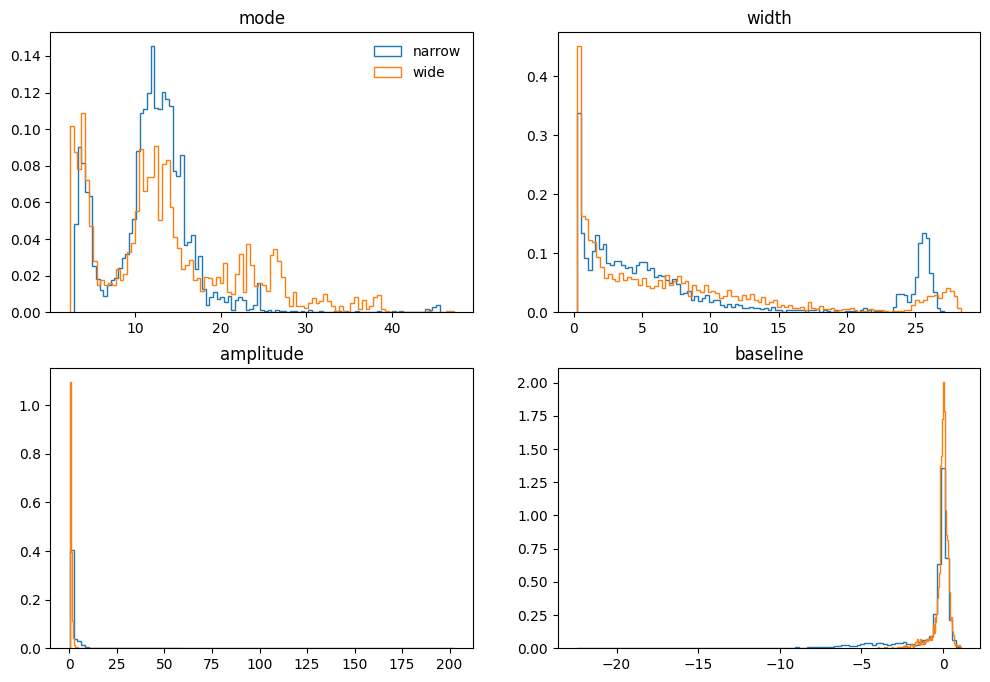

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
all_axs = axs.flatten()
for ii,par in enumerate(['mode', 'width', 'amplitude', 'baseline']):
    ax = all_axs[ii]
    #sns.histplot(dfs[('gaussian', par, 'narrow')], ax=ax, kde=True, label='Gaussian')
    ax.hist( dfs[mask_ng][('gaussian', par, 'narrow')], bins=100, histtype='step', density=True, label='narrow')
    ax.hist( dfs[mask_wg][('gaussian', par, 'wide')],   bins=100, histtype='step', density=True, label='wide' )
    ax.set_title(par)
all_axs[0].legend()
#
for cond in ['narrow', 'wide']:
    print( cond, ( dfs[mask_ng][('gaussian', 'baseline', cond)] < -1 ).mean() )
    print( cond, ( dfs[mask_ng][('gaussian', 'amplitude', cond)] > 2 ).mean() )

In [13]:
from scipy import odr

In [14]:
def odr_1dregression(data, x, y):
    #def f(B,x):
    #    return B[0]*x + B[1]
    #linear_model = odr.Model(f)
    dat = odr.Data(data[x], data[y])
    myodr = odr.ODR(dat, odr.unilinear, beta0=[1., 0.]) # start point = identity
    res = myodr.run()
    return res

def odr_pred(odr_res, x):
    B = odr_res.beta
    return B[0]*x + B[1]

def odr_1dregression_fixed_intercept(data, x, y, intercept):
    def f(B,x):
        return B[0]*x + intercept
    odr_model = odr.Model(f)
    dat = odr.Data(data[x], data[y])
    myodr = odr.ODR(dat, odr_model, beta0=[1.,]) # start point = slope = 1
    res = myodr.run()
    return res

def odr_pred_fixed_intercept(odr_res, x, intercept):
    B = odr_res.beta
    return B[0]*x + intercept

In [15]:
res = odr_1dregression( data=dfs[mask_bg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) )
res.pprint()

Beta: [  3.33423427 -22.99298731]
Beta Std Error: [0.22686401 2.33884646]
Beta Covariance: [[ 0.00330215 -0.03343079]
 [-0.03343079  0.35096921]]
Residual Variance: 15.585990500201543
Inverse Condition #: 0.001817858559918916
Reason(s) for Halting:
  Sum of squares convergence


In [16]:
print( dfs[mask_bg][('gaussian', 'mode', 'narrow')].var() )
print( dfs[mask_bg][('gaussian', 'mode', 'wide')].var() )
res.res_var

18.07899793429989
43.47155839524093


15.585990500201543

## Mode

PearsonRResult(statistic=0.29846033413775186, pvalue=2.286985100605582e-21)
Beta: [  3.33423427 -22.99298731]
Beta Std Error: [0.22686401 2.33884646]
Beta Covariance: [[ 0.00330215 -0.03343079]
 [-0.03343079  0.35096921]]
Residual Variance: 15.585990500201543
Inverse Condition #: 0.001817858559918916
Reason(s) for Halting:
  Sum of squares convergence

Beta: [  3.56879999 -29.05065544]
Beta Std Error: [0.10146898 1.27725682]
Beta Covariance: [[ 0.00041597 -0.0051285 ]
 [-0.0051285   0.06590988]]
Residual Variance: 24.751751136539383
Inverse Condition #: 0.0015921750499343253
Reason(s) for Halting:
  Sum of squares convergence


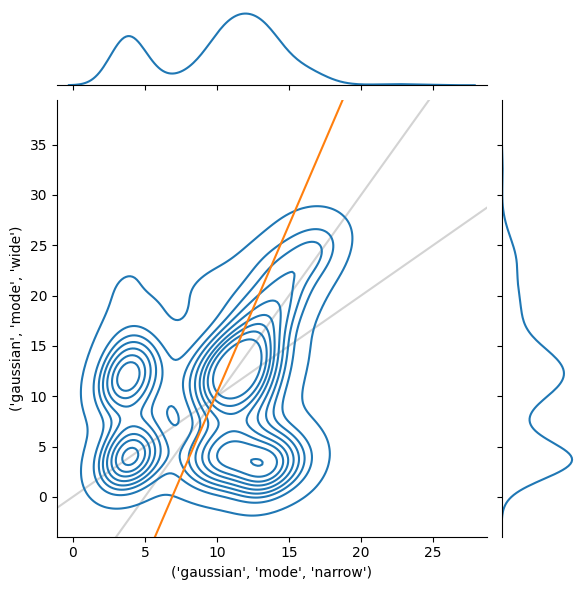

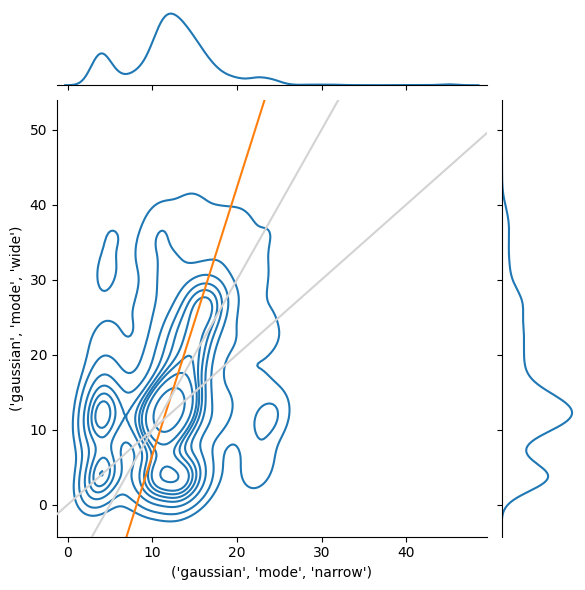

In [18]:
sns.jointplot(data=dfs[mask_bg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='kde', )
plt.axline((10, 10), slope=1, color='lightgrey', zorder=-1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask_bg][('gaussian', 'mode', 'narrow')], dfs[mask_bg][('gaussian', 'mode', 'wide')]) )
res = odr_1dregression( data=dfs[mask_bg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);
##
print()
sns.jointplot(data=dfs[mask_eg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='kde', )
plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000)
stats.pearsonr(dfs[mask_eg][('gaussian', 'mode', 'narrow')], dfs[mask_eg][('gaussian', 'mode', 'wide')])
res = odr_1dregression( data=dfs[mask_eg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);

In [19]:
dfs

model           gaussian                                                                                                                                           \
parameter           mode                                      width                                 amplitude                                  baseline             
range_n             wide     narrow       both      wide2      wide     narrow      both      wide2      wide      narrow      both     wide2      wide    narrow   
subject voxel                                                                                                                                                       
01      0      37.364826  21.124500  37.348385  11.517796  0.341002   0.396827  0.346775   0.906162  1.438429    0.680798  1.289311  0.729588 -0.130019 -0.100848   
        1      33.824623   4.783791  33.821358  11.687057  0.691629   4.528500  0.667084   0.466805  0.748930    0.540905  0.723414  1.072110 -0.531615 -0.537404   
        2      28.557991  11.896777  28.558237  15.473819  0.415108   0.934195  0.399016   1.315624  0.991627    0.328446  0.965211  0.488749 -0.533834 -0.502003   
        3      15.576399  12.634756  15.078053  15.590551  1.232276   2.400554  1.203502   1.414796  0.484945    0.272006  0.293359  0.609456 -0.345589 -0.334171   
        4      11.836634   8.140844  11.579211  11.840950  0.779714   0.545360  1.052765   0.820746  0.961715  153.636470  0.375336  1.067275 -0.108668 -0.120475   
...                  ...        ...        ...        ...       ...        ...       ...        ...       ...         ...       ...       ...       ...       ...   
38      697    10.426326   4.564291   4.016433  10.449670  1.613101  26.400085  5.397981   1.640172  0.361253    1.929290  0.708828  0.374306  0.027523 -1.630308   
        698    33.229786   3.604554   4.515877  13.041175  0.794954  26.579262  3.128798  25.861330  0.306434    0.829503  0.997773  1.959751 -0.010555 -0.724373   
        699    32.148064   6.616162  32.144485  18.932497  1.559922   0.424628  1.571747   0.547694  0.319630    1.000023  0.323219  0.340539  0.006793  0.000684   
        700    10.515281  10.846213   4.627740  10.522858  0.415329  26.150427  3.319563   0.524882  0.751378    2.716299  1.347138  0.613012  0.028433 -2.522691   
        701    10.546851   9.609516   4.604275  10.553507  0.619145  26.092861  4.304541   0.686846  0.530955    2.709397  0.779349  0.526931  0.037476 -2.474706   

model                                                                                                                  lognormal                                   \
parameter                                r2                                        cvr2                                     mode                                    
range_n            both     wide2      wide        narrow      both     wide2      wide    narrow      both     wide2       wide     narrow       both      wide2   
subject voxel                                                                                                                                                       
01      0     -0.096930 -0.242621  0.025210  2.050889e-02  0.013219  0.031572 -0.010679 -0.037111 -0.013963 -0.150426  37.357880  21.101067  37.343750  11.424807   
        1     -0.504734 -0.641905  0.021125  9.863794e-03  0.011212  0.036705 -0.077199 -0.060669 -0.033635 -0.112344  33.805150   4.180238  33.803192  11.662571   
        2     -0.494730 -0.664774  0.028490  1.959443e-02  0.015095  0.043335 -0.078409 -0.051255 -0.040969 -0.139146  28.577208  11.842598  28.558933  15.337356   
        3     -0.312884 -0.462194  0.027097  2.759892e-02  0.014951  0.070238 -0.079311 -0.021471 -0.060922 -0.090663  15.417795  12.327776  15.034226  15.448602   
        4     -0.110317 -0.199313  0.027147  1.359481e-02  0.008204  0.050541 -0.054760 -0.026661 -0.040119 -0.100712  11.764568   8.172389  37.307003  11.772324   
...                 ...       ...      

In [20]:
res = odr_1dregression( data=dfs[mask_bg], y=('gaussian', 'mode', 'narrow'), x=('gaussian', 'mode', 'wide' ) )
res.pprint()

Beta: [0.29985468 6.89672391]
Beta Std Error: [0.02040601 0.25648161]
Beta Covariance: [[ 2.67166268e-05 -2.87540952e-04]
 [-2.87540952e-04  4.22063753e-03]]
Residual Variance: 15.585990491170934
Inverse Condition #: 0.0040981136334301655
Reason(s) for Halting:
  Sum of squares convergence


In [21]:
mask_08 = (dfs[('gaussian', 'mode', 'narrow')] >=  8) & (dfs[('gaussian', 'mode', 'wide')] >=  8)
mask_10 = (dfs[('gaussian', 'mode', 'narrow')] >= 10) & (dfs[('gaussian', 'mode', 'wide')] >= 10)
mask_11 = (dfs[('gaussian', 'mode', 'narrow')] >= 11) & (dfs[('gaussian', 'mode', 'wide')] >= 11)
(mask_bg & mask_10).sum()

367

Beta: [  2.92871294 -21.84466722]
Beta Std Error: [0.15950275 2.10425352]
Beta Covariance: [[ 0.00906056 -0.11853905]
 [-0.11853905  1.57693902]]
Residual Variance: 2.807897338194018
Inverse Condition #: 0.0009687681388983508
Reason(s) for Halting:
  Sum of squares convergence
PearsonRResult(statistic=0.6536820629372465, pvalue=4.219252234485661e-46)


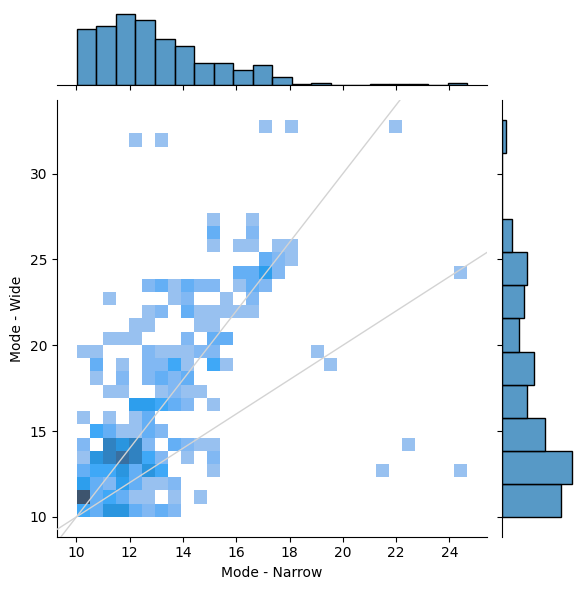

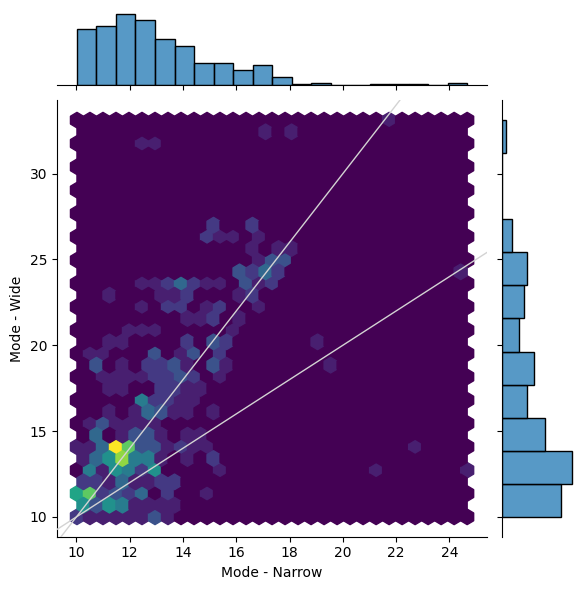

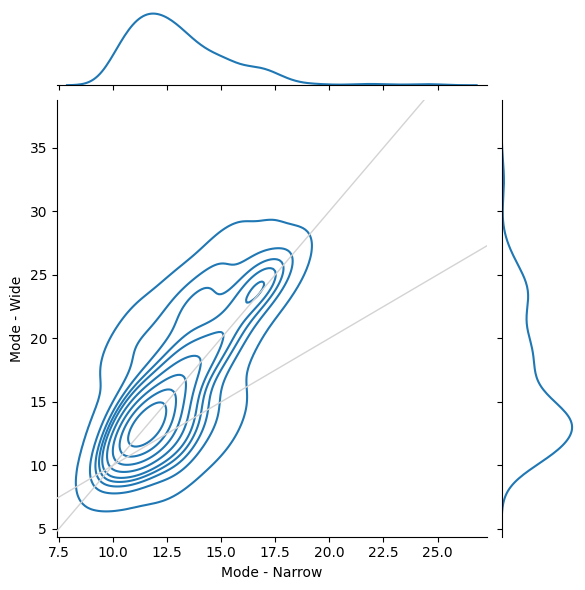

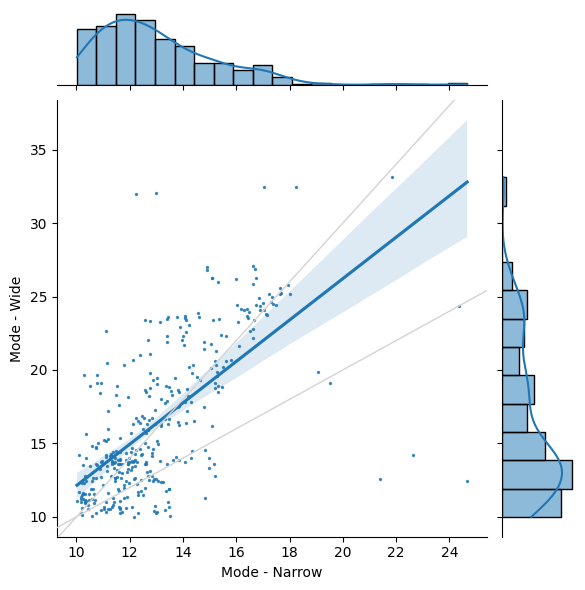

In [23]:
#sns.jointplot(data=dfs[mask_bg & mask_10], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='hist', bins=25) #, cmap='viridis')
mask = mask_bg & mask_10
#mask = mask_bg
#mask = mask_eg & mask_10
#mask = mask_eg
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) ); res.pprint()
for kwargs in [dict(kind='hist', bins=30), dict(kind='hex', gridsize=30, cmap='viridis'), dict(kind='kde'), dict(kind='reg', scatter_kws={'s':2})]:
    sns.jointplot(data=dfs[mask], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), **kwargs) #, cmap='viridis')
    plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000, lw=1)
    plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000, lw=1)
    #xlm = plt.xlim(); ylm = plt.ylim()
    #plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
    #plt.xlim(*xlm); plt.ylim(*ylm);
    plt.xlabel('Mode - Narrow'); plt.ylabel('Mode - Wide'); 
print( stats.pearsonr(dfs[mask][('gaussian', 'mode', 'narrow')], dfs[mask][('gaussian', 'mode', 'wide')]) )

PearsonRResult(statistic=0.32118106172486544, pvalue=9.697176444688433e-72)

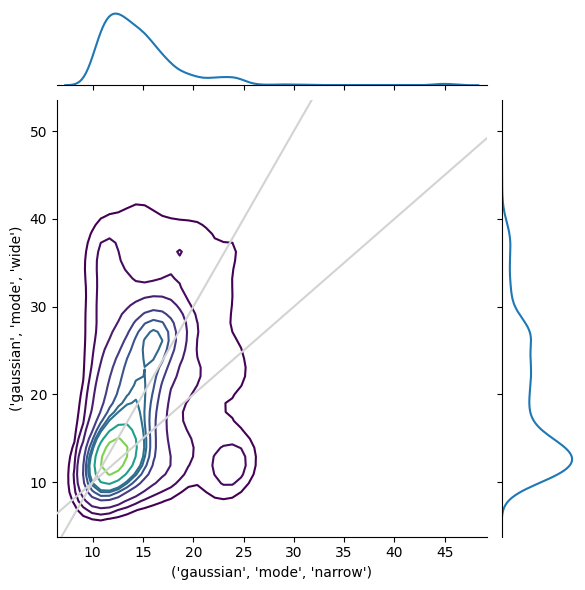

In [24]:
### same with either one good
sns.jointplot(data=dfs[mask_eg & mask_10], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='kde', gridsize=50, cmap='viridis')
plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000)
stats.pearsonr(dfs[mask_eg & mask_10][('gaussian', 'mode', 'narrow')], dfs[mask_eg & mask_10][('gaussian', 'mode', 'wide')])

## Width

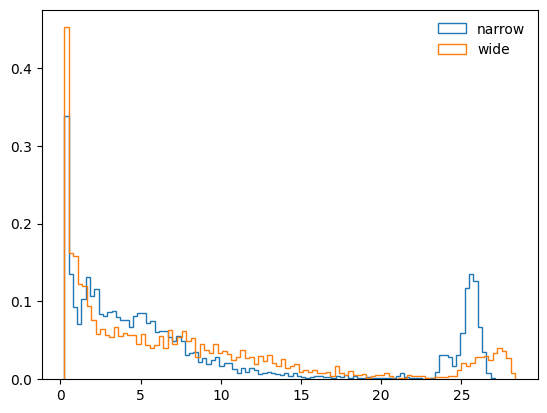

In [44]:
plt.hist( dfs[mask_ng][('gaussian', 'width', 'narrow')], bins=100, histtype='step', density=True, label='narrow')
plt.hist( dfs[mask_wg][('gaussian', 'width', 'wide')],   bins=100, histtype='step', density=True, label='wide' )
plt.legend()

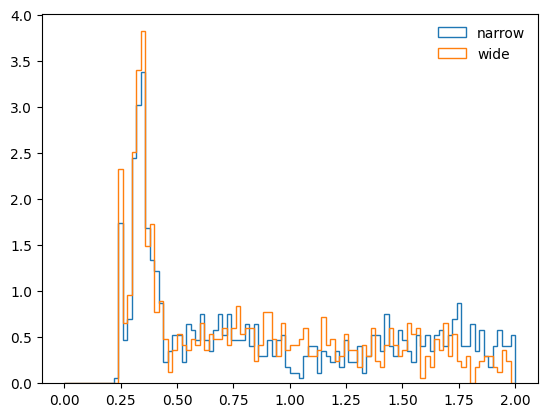

In [26]:
plt.hist( dfs[mask_ng][('gaussian', 'width', 'narrow')], bins=100, histtype='step', density=True, label='narrow', range=(0,2))
plt.hist( dfs[mask_wg][('gaussian', 'width', 'wide')],   bins=100, histtype='step', density=True, label='wide'  , range=(0,2))
plt.legend()

In [27]:
print( ( dfs[mask_ng][('gaussian', 'width', 'narrow')] < .5 ).mean() )
print( ( dfs[mask_wg][('gaussian', 'width', 'wide')] < .5 ).mean() )

0.08982903506230078
0.12376987130961394


In [28]:
print( ( dfs[mask_ng][('gaussian', 'width', 'narrow')] < 1 ).mean() )
print( ( dfs[mask_wg][('gaussian', 'width', 'wide')] < 1 ).mean() )

0.1506809620399884
0.20552611657834974


In [29]:
print( ( dfs[mask_ng][('gaussian', 'width', 'narrow')] > 15 ).mean() )
print( ( dfs[mask_wg][('gaussian', 'width', 'wide')] > 30 ).mean() )

0.20950449145175312
0.0


In [30]:
mask_width_n_g1 = dfs[('gaussian', 'width', 'narrow')] > 1
mask_width_w_g1 = dfs[('gaussian', 'width', 'wide')] > 1
mask_width_b_g1 = mask_width_n_g1 & mask_width_w_g1
#
mask_width_n_g05 = dfs[('gaussian', 'width', 'narrow')] > .5
mask_width_w_g05 = dfs[('gaussian', 'width', 'wide')] > .5
mask_width_b_g05 = mask_width_n_g05 & mask_width_w_g05
#
mask_width_n_l22 = dfs[('gaussian', 'width', 'narrow')] < 22
mask_width_w_l22 = dfs[('gaussian', 'width', 'wide')] < 22
mask_width_b_l22 = mask_width_n_l22 & mask_width_w_l22
#
mask_width_n_l11 = dfs[('gaussian', 'width', 'narrow')] < 11

590 voxels
Beta: [ 2.82852519 -8.4548846 ]
Beta Std Error: [0.28415833 1.67479939]
Beta Covariance: [[ 0.00684964 -0.03905549]
 [-0.03905549  0.23794289]]
Residual Variance: 11.788345444435349
Inverse Condition #: 0.004244468373449749
Reason(s) for Halting:
  Sum of squares convergence

Beta: [1.41475206]
Beta Std Error: [0.04140486]
Beta Covariance: [[0.00013786]]
Residual Variance: 12.435620760208957
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
PearsonRResult(statistic=0.1674535816282727, pvalue=4.356615017358356e-05)


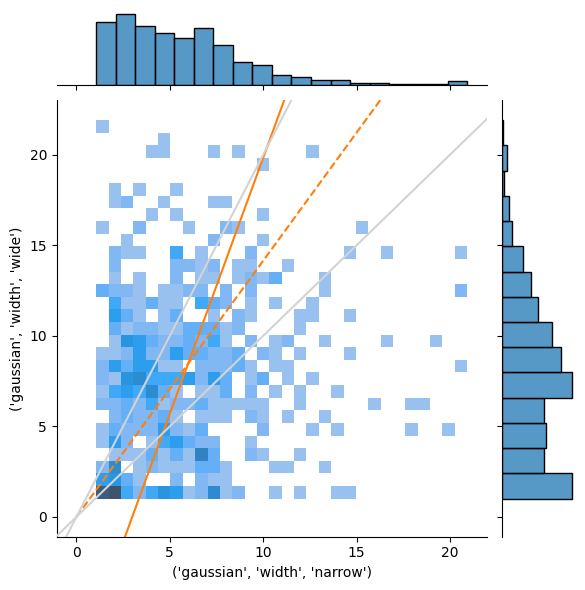

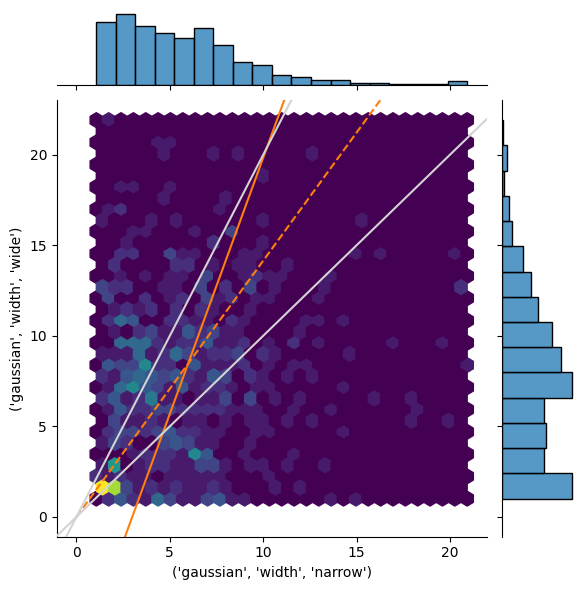

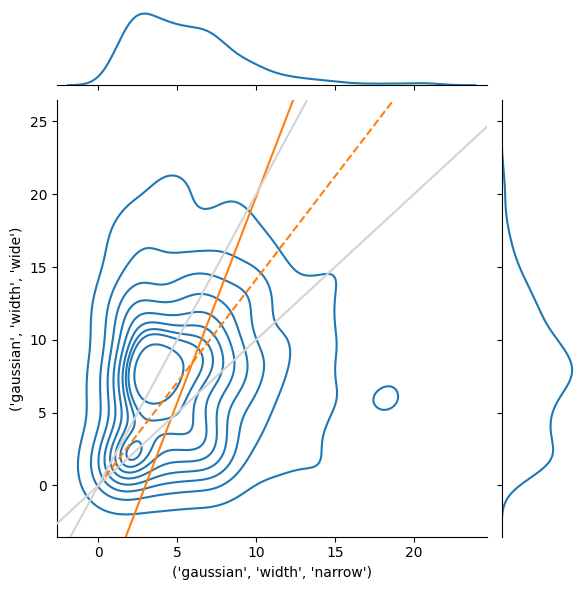

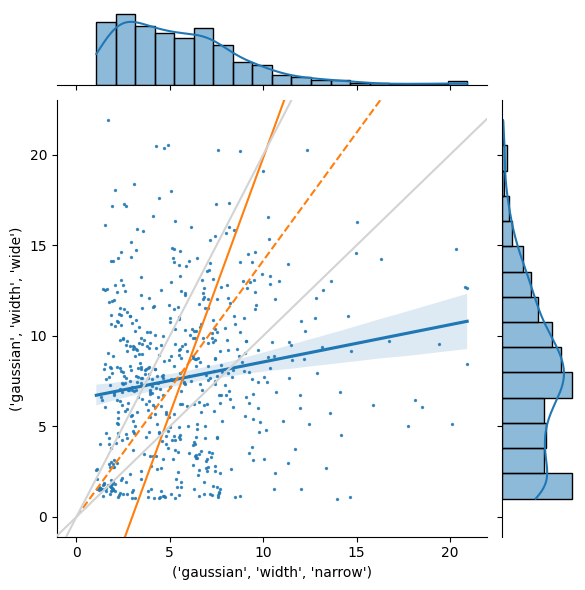

In [35]:
mask = mask_bg & mask_width_b_g1 & mask_width_b_l22
print(dfs[mask].shape[0], 'voxels')
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide' ) ); res.pprint(); print()
res2 = odr_1dregression_fixed_intercept( data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide' ), intercept=0 ); res2.pprint()
for kwargs in [dict(kind='hist', bins=30), dict(kind='hex', gridsize=30, cmap='viridis'), dict(kind='kde'), dict(kind='reg', scatter_kws={'s':2})]:
    sns.jointplot(data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide'), **kwargs )
    plt.axline((0, 0), slope=1, color='lightgrey', zorder=1000)
    plt.axline((0, 0), slope=2, color='lightgrey', zorder=1000)
    xlm = plt.xlim(); ylm = plt.ylim()
    plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
    plt.plot( np.linspace(0,25), odr_pred_fixed_intercept(res2, np.linspace(0,25), intercept=0), c='C1', ls='--')
    plt.xlim(*xlm); plt.ylim(*ylm);
print( stats.pearsonr(dfs[mask][('gaussian', 'width', 'narrow')], dfs[mask][('gaussian', 'width', 'wide')]) )


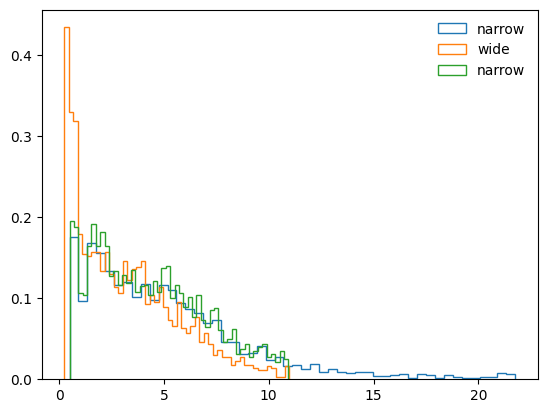

In [34]:
plt.hist( dfs[mask_ng & mask_width_n_g05 & mask_width_n_l22][('gaussian', 'width', 'narrow')], bins=50, histtype='step', density=True, label='narrow')
plt.hist( dfs[mask_wg & mask_width_w_g05 & mask_width_w_l22][('gaussian', 'width', 'wide')]/2, bins=50, histtype='step', density=True, label='wide' )
plt.hist( dfs[mask_ng & mask_width_n_g05 & mask_width_n_l11][('gaussian', 'width', 'narrow')], bins=50, histtype='step', density=True, label='narrow')
plt.legend()

In [33]:
print( stats.ks_2samp( dfs[mask_ng & mask_width_n_g05 & mask_width_n_l22][('gaussian', 'width', 'narrow')],
                dfs[mask_wg & mask_width_w_g05 & mask_width_w_l22][('gaussian', 'width', 'wide')]/2) )
print( stats.ks_2samp( dfs[mask_ng & mask_width_n_g05 & mask_width_n_l11][('gaussian', 'width', 'narrow')],
                dfs[mask_wg & mask_width_w_g05 & mask_width_w_l22][('gaussian', 'width', 'wide')]/2) )

KstestResult(statistic=0.2160035696102424, pvalue=2.0588187341224582e-46, statistic_location=4.1683225, statistic_sign=-1)
KstestResult(statistic=0.1846853518629998, pvalue=8.385341385367338e-33, statistic_location=1.4164026, statistic_sign=-1)


In [36]:
mask_wrange = (dfs[('gaussian', 'width', 'narrow')] <=  15) & (dfs[('gaussian', 'width', 'wide')] <=  30)

PearsonRResult(statistic=0.09959022621673569, pvalue=0.05663632821547662)
Beta: [ 2.48484421 -7.53890451]
Beta Std Error: [0.3250062  2.44751806]
Beta Covariance: [[ 0.00169604 -0.01140072]
 [-0.01140072  0.09618423]]
Residual Variance: 62.279903789557025
Inverse Condition #: 0.005951197756377805
Reason(s) for Halting:
  Iteration limit reached


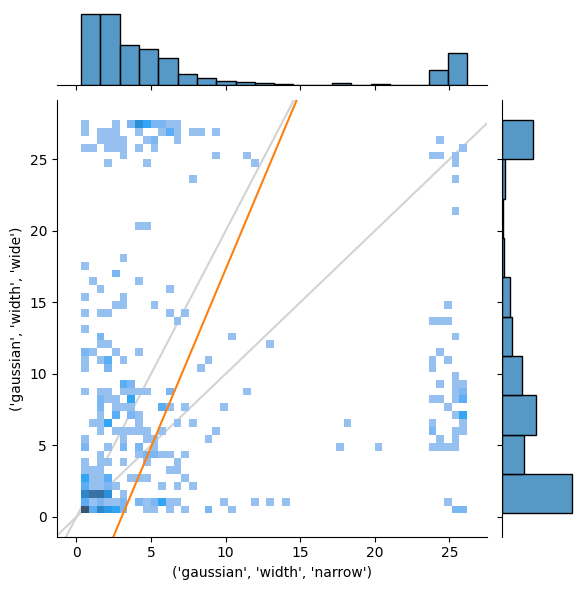

In [37]:
mask = mask_bg & mask_10 #& mask_wrange
sns.jointplot(data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide'), kind='hist', bins=50 )
plt.axline((0, 0), slope=1, color='lightgrey', zorder=-1000)
plt.axline((0, 0), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask][('gaussian', 'width', 'narrow')], dfs[mask][('gaussian', 'width', 'wide')]) )
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);


# Amplitude

In [49]:
amp_th = 2
print( ( dfs[mask_bg][('gaussian', 'amplitude', 'narrow')] > amp_th ).mean() )
print( ( dfs[mask_bg][('gaussian', 'amplitude', 'wide')] > amp_th ).mean() )

0.20557851239669422
0.024793388429752067


In [50]:
mask_reasonable_amp = ( dfs[('gaussian', 'amplitude', 'narrow')] < amp_th ) & ( dfs[('gaussian', 'amplitude', 'wide')] < amp_th )

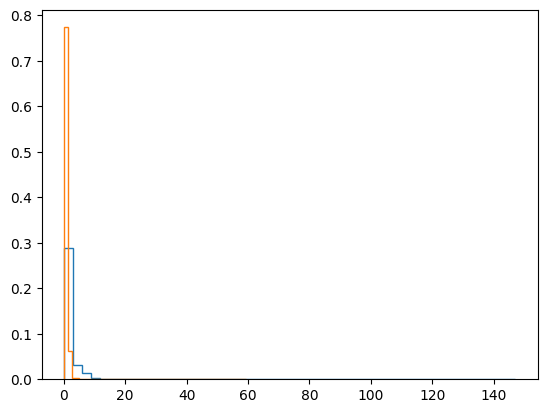

In [51]:
plt.hist( dfs[mask_bg][('gaussian', 'amplitude', 'narrow')], histtype='step', bins=50, density=True)
plt.hist( dfs[mask_bg][('gaussian', 'amplitude', 'wide')],   histtype='step', bins=50, density=True);

Beta: [0.64762734 0.21219164]
Beta Std Error: [0.04211545 0.03177169]
Beta Covariance: [[ 0.01858917 -0.01271298]
 [-0.01271298  0.01057932]]
Residual Variance: 0.09541636700539106
Inverse Condition #: 0.052315932136031494
Reason(s) for Halting:
  Sum of squares convergence
PearsonRResult(statistic=0.18681482045779826, pvalue=2.425525528387545e-07)


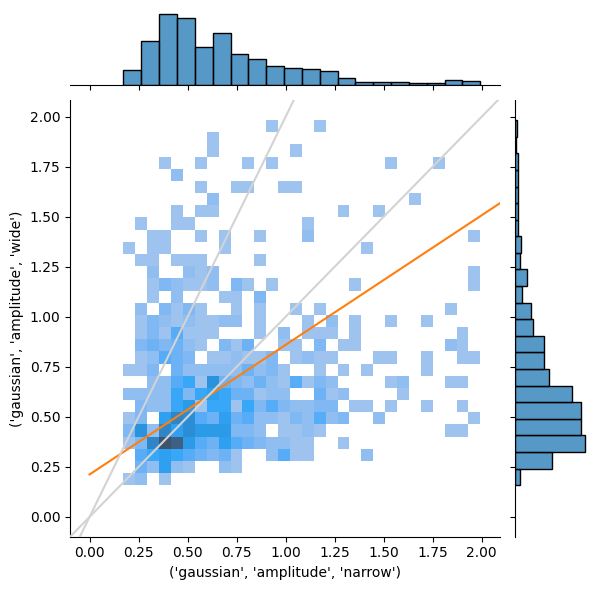

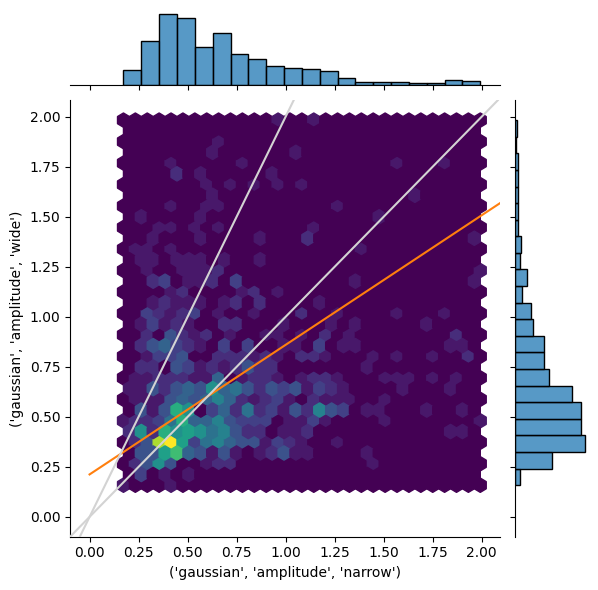

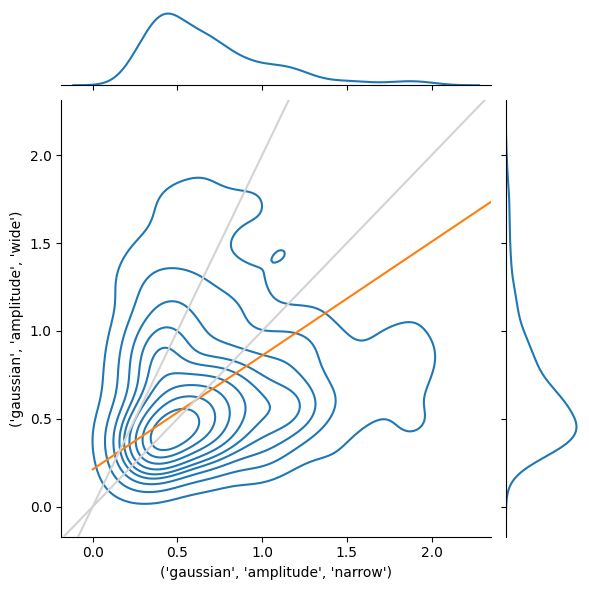

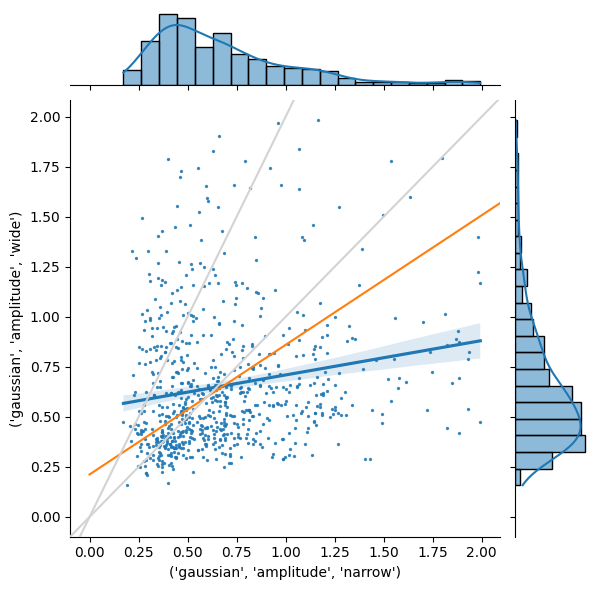

In [52]:
mask = mask_bg & mask_reasonable_amp
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'amplitude', 'narrow'), y=('gaussian', 'amplitude', 'wide' ) ); res.pprint()
for kwargs in [dict(kind='hist', bins=30), dict(kind='hex', gridsize=30, cmap='viridis'), dict(kind='kde'), dict(kind='reg', scatter_kws={'s':2})]:
    sns.jointplot(data=dfs[mask], x=('gaussian', 'amplitude', 'narrow'), y=('gaussian', 'amplitude', 'wide'), **kwargs)
    plt.axline((0, 0), slope=1, color='lightgrey', zorder=1000)
    plt.axline((0, 0), slope=2, color='lightgrey', zorder=1000)
    xlm = plt.xlim(); ylm = plt.ylim()
    plt.plot( np.linspace(0,15), odr_pred(res, np.linspace(0,15)), c='C1')
    plt.xlim(*xlm); plt.ylim(*ylm);
print( stats.pearsonr(dfs[mask][('gaussian', 'amplitude', 'narrow')], dfs[mask][('gaussian', 'amplitude', 'wide')]) )

In [53]:
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'amplitude', 'wide'), y=('gaussian', 'amplitude', 'narrow' ) ); res.pprint()

Beta: [ 1.5428977  -0.32685843]
Beta Std Error: [0.10030333 0.06889108]
Beta Covariance: [[ 0.10544059 -0.06907399]
 [-0.06907399  0.04973969]]
Residual Variance: 0.09541636817807232
Inverse Condition #: 0.03982440258619642
Reason(s) for Halting:
  Sum of squares convergence


PearsonRResult(statistic=0.06219682372298281, pvalue=0.05305366999143778)
PearsonRResult(statistic=0.431429200139774, pvalue=1.7368641325047688e-35)
Beta: [0.94344597 0.00249533]
Beta Std Error: [0.04343634 0.01288295]
Beta Covariance: [[0.02902614 0.00112107]
 [0.00112107 0.00255337]]
Residual Variance: 0.0650005686619496
Inverse Condition #: 0.3834558380241875
Reason(s) for Halting:
  Sum of squares convergence


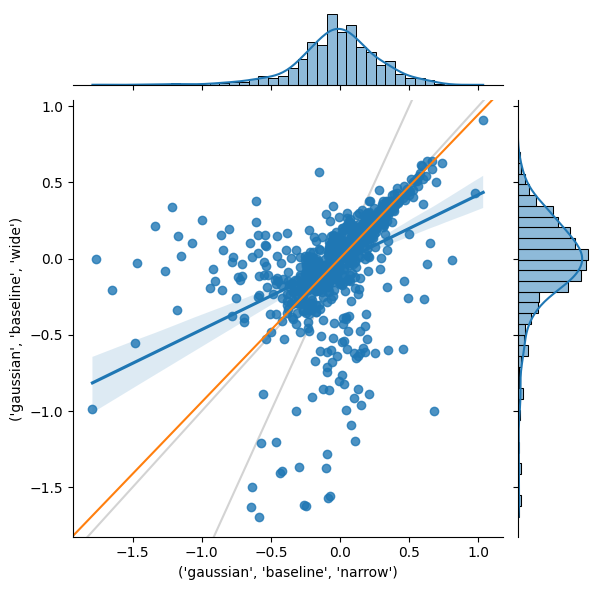

In [60]:
sns.jointplot(data=dfs[mask_bg & mask_reasonable_amp], x=('gaussian', 'baseline', 'narrow'), y=('gaussian', 'baseline', 'wide'), kind='reg', )
plt.axline((0, 0), slope=1, color='lightgrey', zorder=-1000)
plt.axline((0, 0), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask_bg][('gaussian', 'baseline', 'narrow')], dfs[mask_bg][('gaussian', 'baseline', 'wide')]) )
print( stats.pearsonr(dfs[mask_bg & mask_reasonable_amp][('gaussian', 'baseline', 'narrow')], dfs[mask_bg & mask_reasonable_amp][('gaussian', 'baseline', 'wide')]) )
#
res = odr_1dregression( data=dfs[mask_bg & mask_reasonable_amp], x=('gaussian', 'baseline', 'wide'), y=('gaussian', 'baseline', 'narrow' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( xlm, odr_pred(res, np.array(xlm)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);

# With lognormal

In [70]:
for range_n in ['narrow', 'wide']:
    print( range_n, ( dfs[('lognormal', 'cvr2', range_n)] > 0.01 ).sum() )
print( 'both good', ( (dfs[('lognormal', 'cvr2', 'narrow')] > 0.01) & (dfs[('lognormal', 'cvr2', 'wide')] > 0.01) ).sum() )

narrow 3465
wide 2687
both good 995


In [71]:
# mask narrow good, mask wide good, mask both good, mask either one good
mask_ng_logN = dfs[('lognormal', 'cvr2', 'narrow')] > 0.01
mask_wg_logN = dfs[('lognormal', 'cvr2', 'wide')] > 0.01
mask_bg_logN = (mask_ng_logN & mask_wg_logN)
mask_eg_logN = (mask_ng_logN | mask_wg_logN)
print(mask_ng_logN.sum(), mask_wg_logN.sum(), mask_bg_logN.sum(), mask_eg_logN.sum(), 'over', len(mask_bg_logN) )
print(mask_ng_logN.mean(), mask_wg_logN.mean(), mask_bg_logN.mean(), mask_eg_logN.mean())

3465 2687 995 5157 over 27327
0.12679767263146338 0.09832766128737147 0.036410875690708826 0.18871445822812602


## Distributions

narrow 0.2932178932178932
narrow 0.29668109668109666
wide 0.049927849927849925
wide 0.06724386724386724


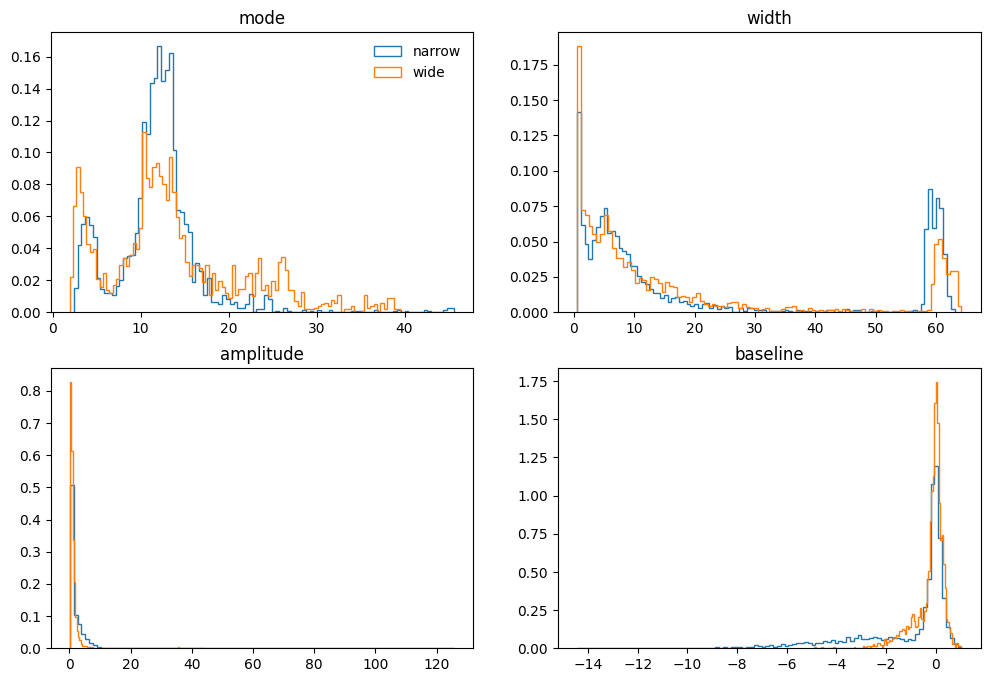

In [72]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
all_axs = axs.flatten()
for ii,par in enumerate(['mode', 'width', 'amplitude', 'baseline']):
    ax = all_axs[ii]
    ax.hist( dfs[mask_ng_logN][('lognormal', par, 'narrow')], bins=100, histtype='step', density=True, label='narrow')
    ax.hist( dfs[mask_wg_logN][('lognormal', par, 'wide')],   bins=100, histtype='step', density=True, label='wide' )
    ax.set_title(par)
all_axs[0].legend()
#
for cond in ['narrow', 'wide']:
    print( cond, ( dfs[mask_ng_logN][('lognormal', 'baseline', cond)] < -1 ).mean() )
    print( cond, ( dfs[mask_ng_logN][('lognormal', 'amplitude', cond)] > 2 ).mean() )

## Mode

PearsonRResult(statistic=0.33903768303195764, pvalue=3.4686956937576365e-28)
Beta: [  2.89102038 -18.7783301 ]
Beta Std Error: [0.17056954 1.78876321]
Beta Covariance: [[ 0.00237953 -0.0245016 ]
 [-0.0245016   0.26169384]]
Residual Variance: 12.22678315236445
Inverse Condition #: 0.0017941564055015417
Reason(s) for Halting:
  Sum of squares convergence

Beta: [  3.73787045 -31.14014965]
Beta Std Error: [0.11077217 1.39232009]
Beta Covariance: [[ 0.00054412 -0.00672265]
 [-0.00672265  0.08596249]]
Residual Variance: 22.551175644684783
Inverse Condition #: 0.0014528448082809097
Reason(s) for Halting:
  Sum of squares convergence


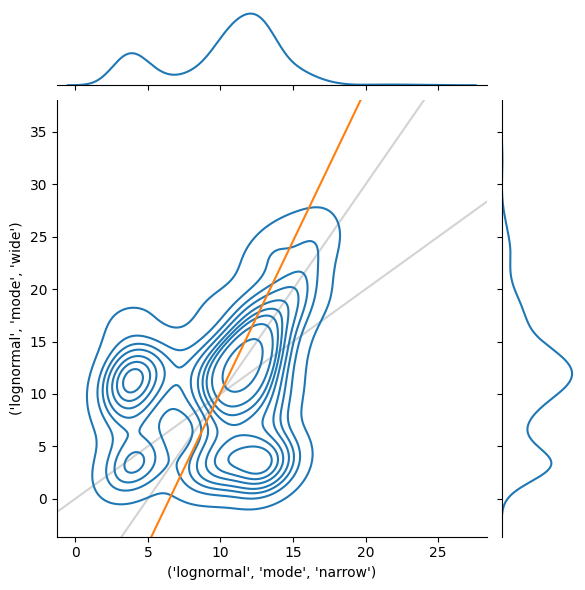

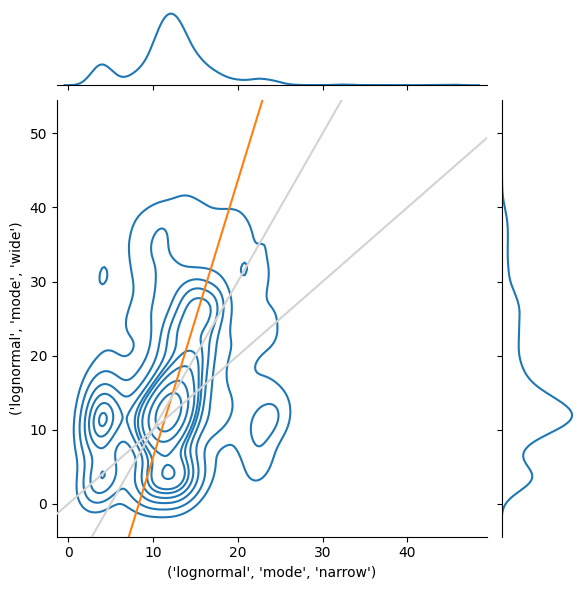

In [73]:
sns.jointplot(data=dfs[mask_bg_logN], x=('lognormal', 'mode', 'narrow'), y=('lognormal', 'mode', 'wide'), kind='kde', )
plt.axline((10, 10), slope=1, color='lightgrey', zorder=-1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask_bg_logN][('lognormal', 'mode', 'narrow')], dfs[mask_bg_logN][('lognormal', 'mode', 'wide')]) )
res = odr_1dregression( data=dfs[mask_bg_logN], x=('lognormal', 'mode', 'narrow'), y=('lognormal', 'mode', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);
##
print()
sns.jointplot(data=dfs[mask_eg_logN], x=('lognormal', 'mode', 'narrow'), y=('lognormal', 'mode', 'wide'), kind='kde', )
plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000)
stats.pearsonr(dfs[mask_eg_logN][('lognormal', 'mode', 'narrow')], dfs[mask_eg_logN][('lognormal', 'mode', 'wide')])
res = odr_1dregression( data=dfs[mask_eg_logN], x=('lognormal', 'mode', 'narrow'), y=('lognormal', 'mode', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);

In [74]:
mask_10_logN = (dfs[('lognormal', 'mode', 'narrow')] >= 10) & (dfs[('lognormal', 'mode', 'wide')] >= 10)
(mask_bg_logN & mask_10_logN).sum()

432

Beta: [  2.84780467 -20.88371914]
Beta Std Error: [0.13920536 1.79166581]
Beta Covariance: [[ 0.00880774 -0.11253929]
 [-0.11253929  1.459038  ]]
Residual Variance: 2.200125272499554
Inverse Condition #: 0.0009277859699316788
Reason(s) for Halting:
  Sum of squares convergence
PearsonRResult(statistic=0.6637789859989285, pvalue=3.323285568720554e-56)


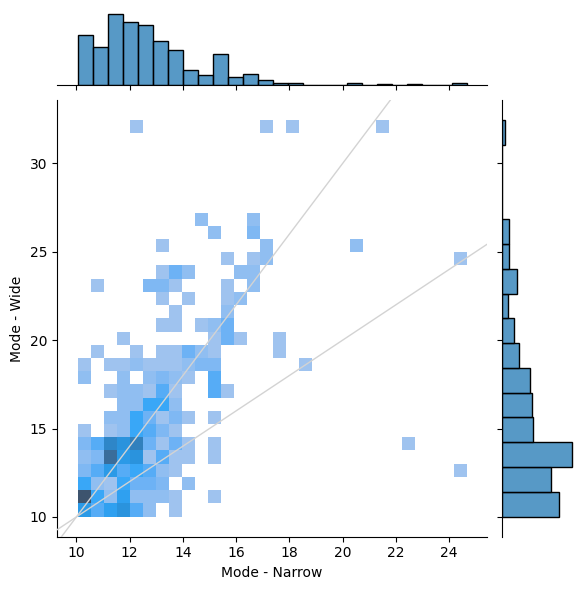

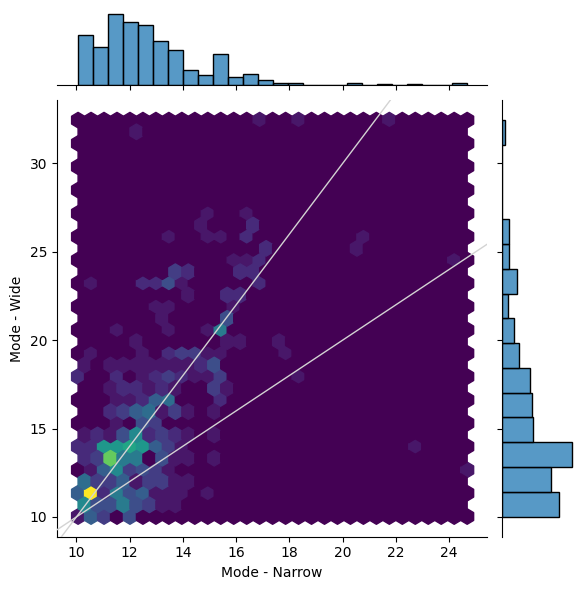

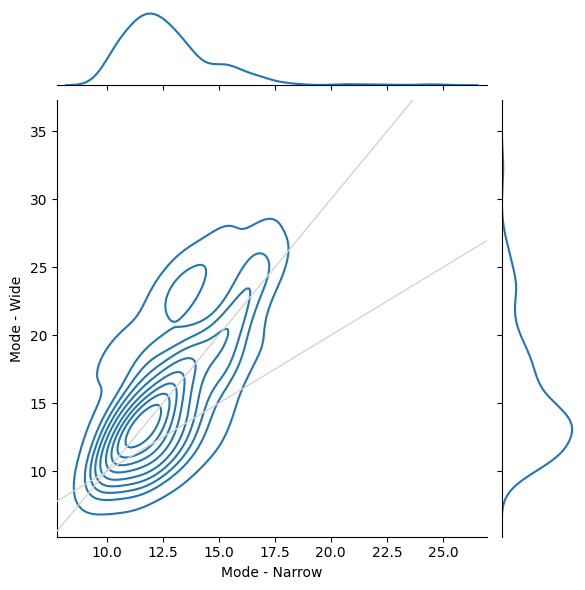

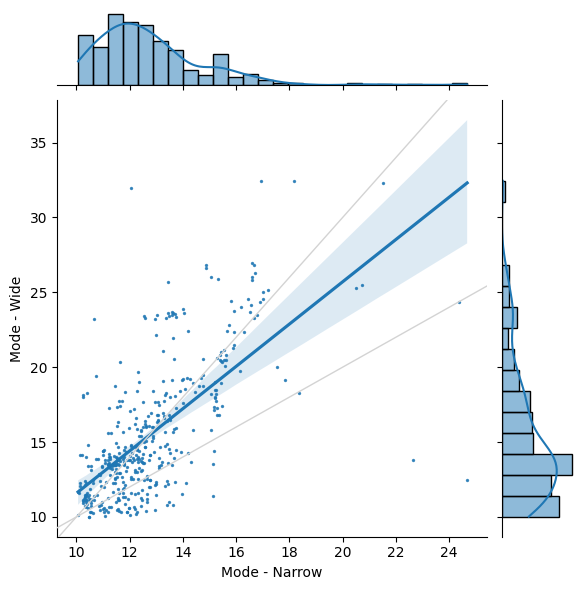

In [75]:
mask = mask_bg_logN & mask_10_logN
#mask = mask_bg_logN
#mask = mask_eg_logN & mask_10_logN
#mask = mask_eg_logN
res = odr_1dregression( data=dfs[mask], x=('lognormal', 'mode', 'narrow'), y=('lognormal', 'mode', 'wide' ) ); res.pprint()
for kwargs in [dict(kind='hist', bins=30), dict(kind='hex', gridsize=30, cmap='viridis'), dict(kind='kde'), dict(kind='reg', scatter_kws={'s':2})]:
    sns.jointplot(data=dfs[mask], x=('lognormal', 'mode', 'narrow'), y=('lognormal', 'mode', 'wide'), **kwargs) #, cmap='viridis')
    plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000, lw=1)
    plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000, lw=1)
    #xlm = plt.xlim(); ylm = plt.ylim()
    #plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
    #plt.xlim(*xlm); plt.ylim(*ylm);
    plt.xlabel('Mode - Narrow'); plt.ylabel('Mode - Wide'); 
print( stats.pearsonr(dfs[mask][('lognormal', 'mode', 'narrow')], dfs[mask][('lognormal', 'mode', 'wide')]) )

# Focus on voxels for which mode ≈ 0

(There used to be a problem)

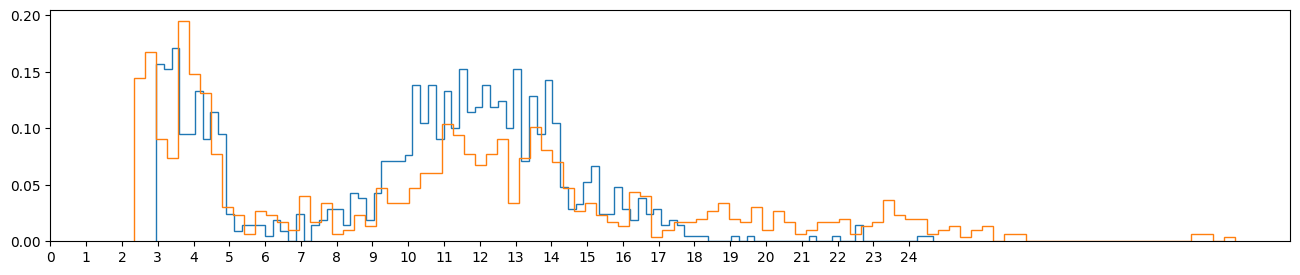

In [61]:
plt.figure(figsize=(16, 3))
plt.hist( dfs[mask_bg][('gaussian', 'mode', 'narrow')], histtype='step', bins=100, density=True, label='narrow');
plt.hist( dfs[mask_bg][('gaussian', 'mode', 'wide')], histtype='step', bins=100, density=True, label='narrow');
plt.xticks(np.arange(0, 25, 1));

In [62]:
mode_th = 1.5
mask_m0 = dfs[('gaussian', 'mode', 'narrow')].abs() < mode_th
dfs[mask_bg & mask_m0]

Empty DataFrame
Columns: [(gaussian, mode, wide), (gaussian, mode, narrow), (gaussian, mode, both), (gaussian, mode, wide2), (gaussian, width, wide), (gaussian, width, narrow), (gaussian, width, both), (gaussian, width, wide2), (gaussian, amplitude, wide), (gaussian, amplitude, narrow), (gaussian, amplitude, both), (gaussian, amplitude, wide2), (gaussian, baseline, wide), (gaussian, baseline, narrow), (gaussian, baseline, both), (gaussian, baseline, wide2), (gaussian, r2, wide), (gaussian, r2, narrow), (gaussian, r2, both), (gaussian, r2, wide2), (gaussian, cvr2, wide), (gaussian, cvr2, narrow), (gaussian, cvr2, both), (gaussian, cvr2, wide2), (lognormal, mode, wide), (lognormal, mode, narrow), (lognormal, mode, both), (lognormal, mode, wide2), (lognormal, width, wide), (lognormal, width, narrow), (lognormal, width, both), (lognormal, width, wide2), (lognormal, amplitude, wide), (lognormal, amplitude, narrow), (lognormal, amplitude, both), (lognormal, amplitude, wide2), (lognormal, baseline, wide), (lognormal, baseline, narrow), (lognormal, baseline, both), (lognormal, baseline, wide2), (lognormal, r2, wide), (lognormal, r2, narrow), (lognormal, r2, both), (lognormal, r2, wide2), (lognormal, cvr2, wide), (lognormal, cvr2, narrow), (lognormal, cvr2, both), (lognormal, cvr2, wide2)]
Index: []

In [63]:
dfs[mask_bg & mask_m0].index.get_level_values('subject').unique()

Index([], dtype='object', name='subject')

In [64]:
dfs[mask_bg & mask_m0].loc['07'].index

KeyError: '07'

2024-05-29 17:08:52.322700: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


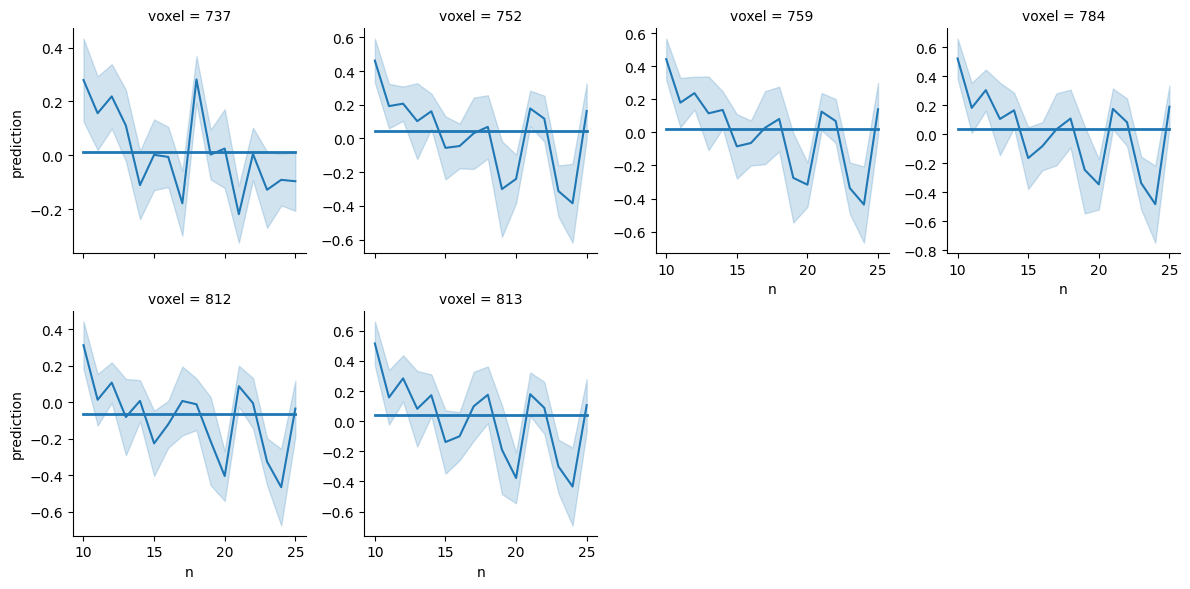

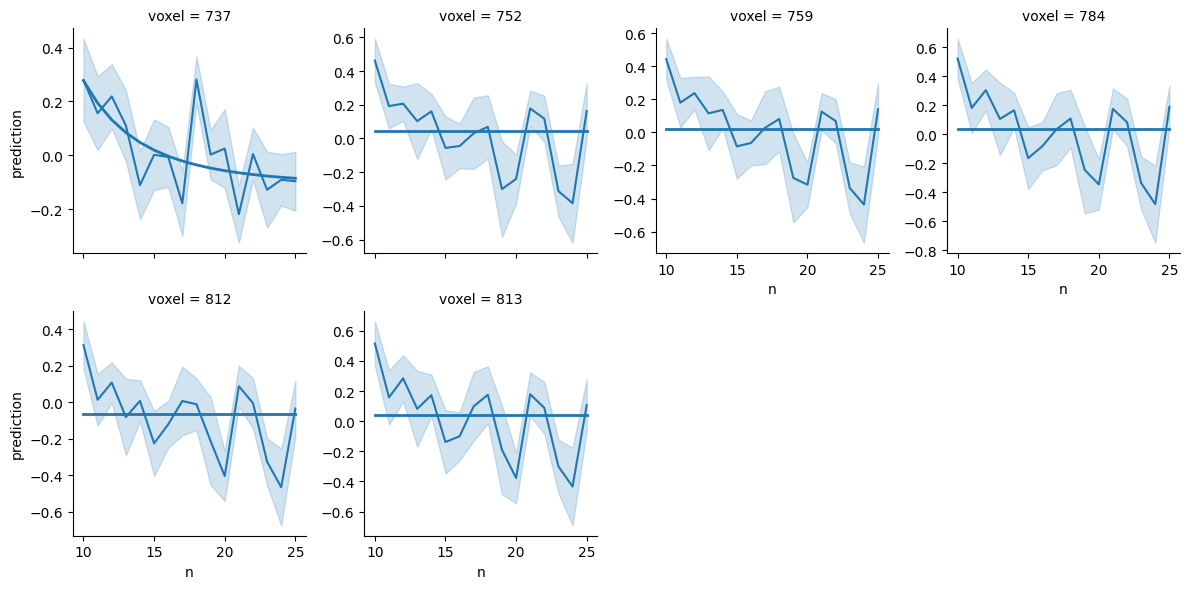

In [100]:
plot_prf_predictions('07', bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc['07'].index, gaussian=True, range_n='narrow', smoothed=True)
plot_prf_predictions('07', bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc['07'].index, gaussian=False, range_n='narrow', smoothed=True)

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


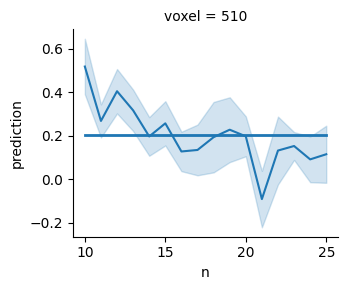

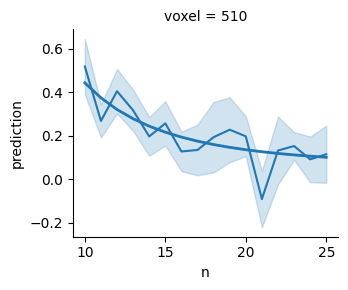

In [101]:
subject = '08'
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index, gaussian=True, range_n='narrow', smoothed=True)
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index, gaussian=False, range_n='narrow', smoothed=True)

In [217]:
dfs[mask_bg & mask_m0].loc[subject].index[:20]

Index([27, 32, 34, 35, 37, 57, 60, 85, 86, 87, 91, 114, 117, 119, 120, 122, 123, 124, 126, 145], dtype='int64', name='voxel')

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


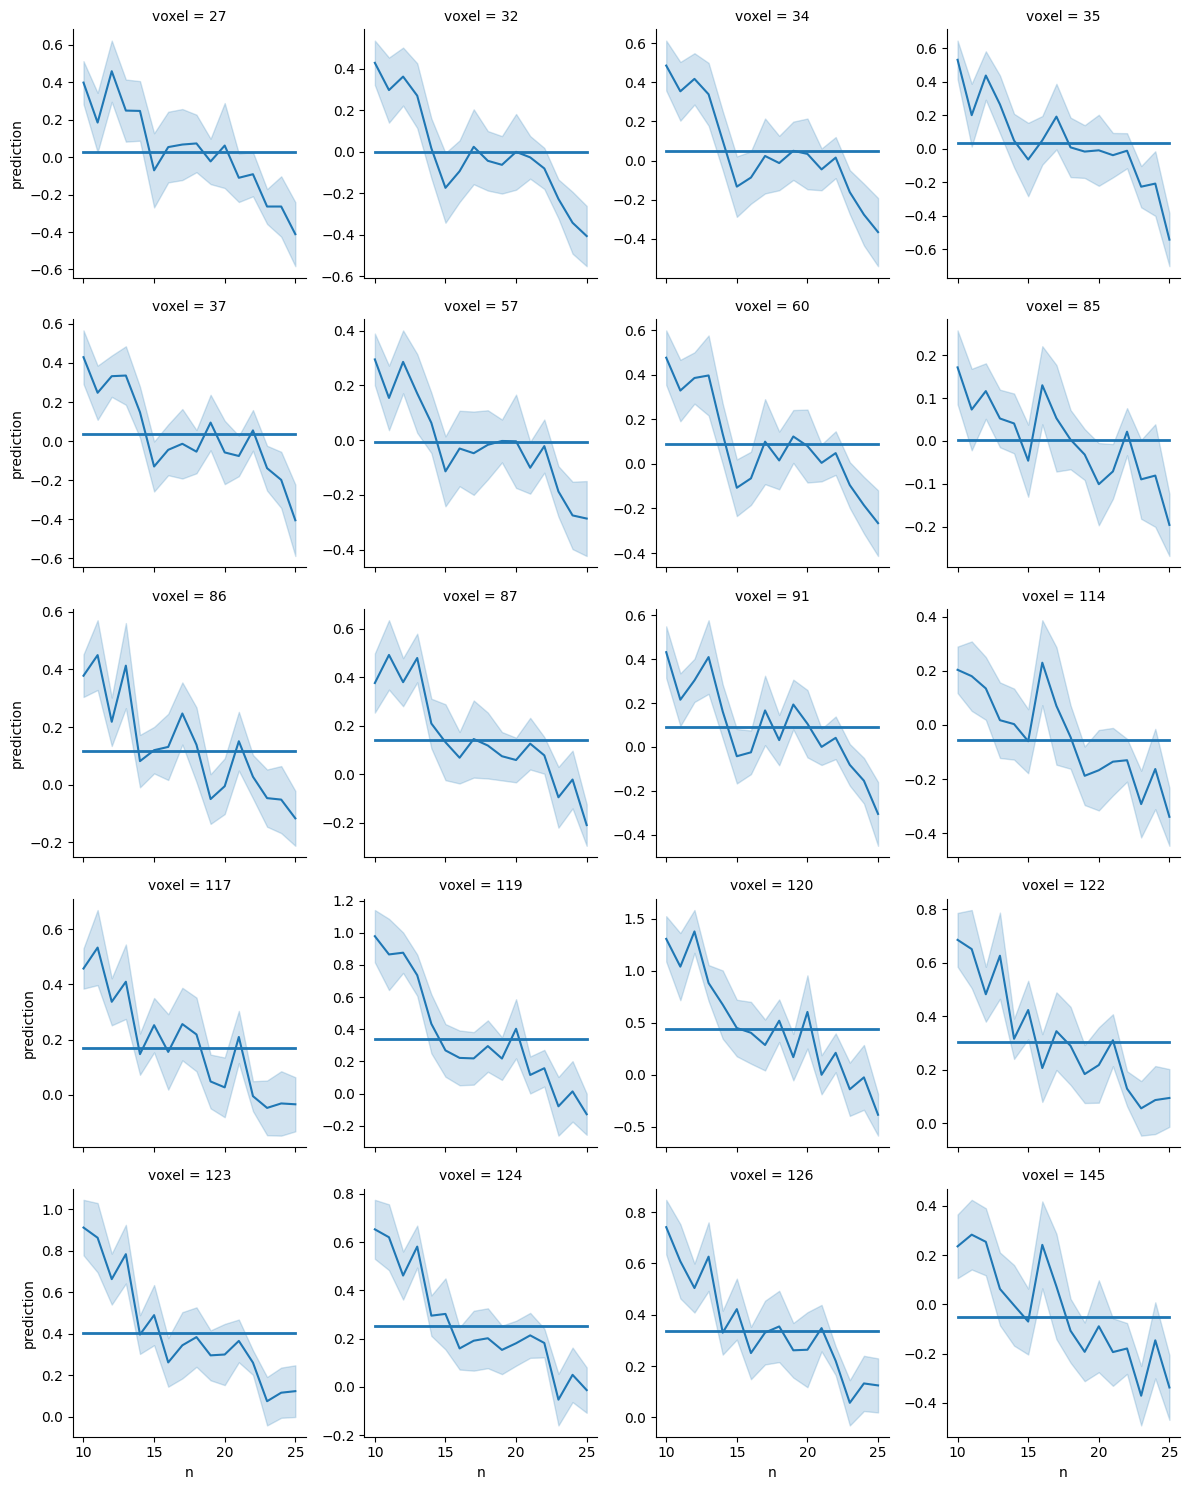

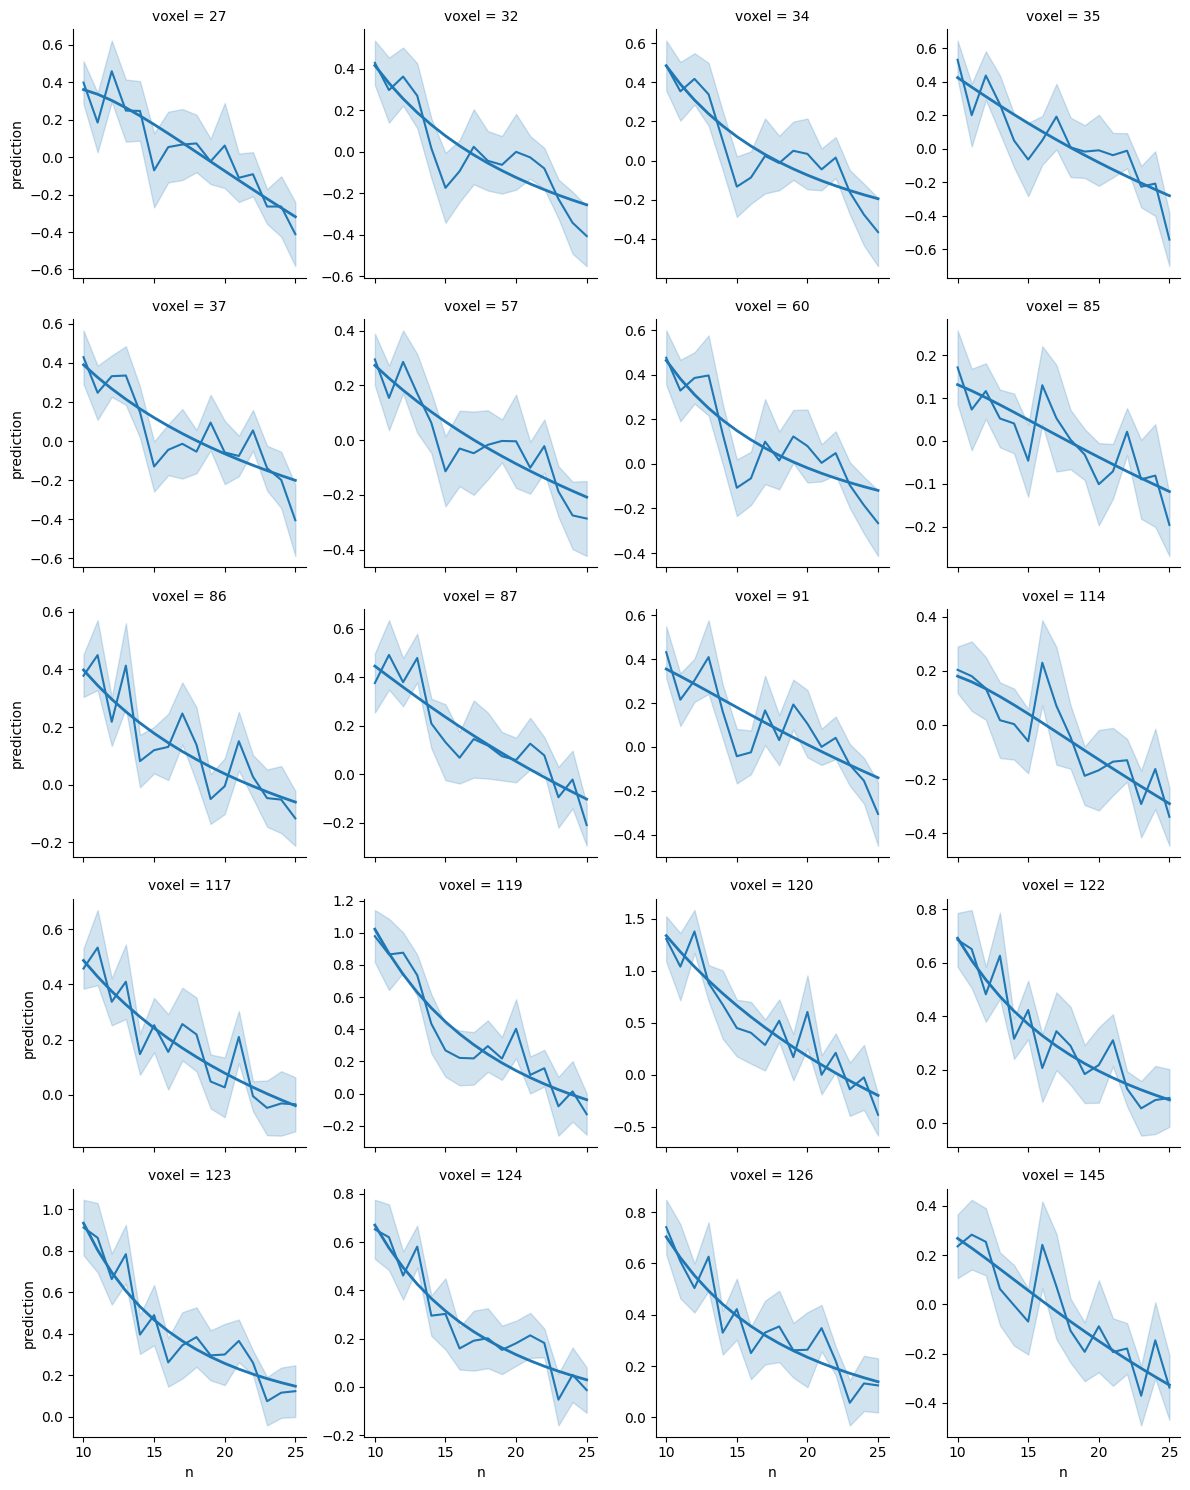

In [218]:
subject = '12'
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index[:20], gaussian=True, range_n='narrow', smoothed=True)
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index[:20], gaussian=False, range_n='narrow', smoothed=True)

# Ideal tuning curves

In [119]:
import apc_utils as apc

Text(0.5, 0, 'Number')

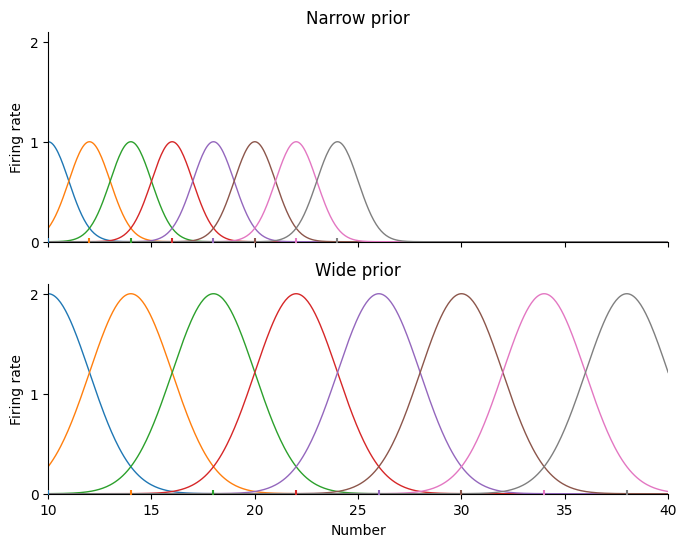

In [141]:
def norm(x, mu, w):
    return np.exp(-.5*((x-mu)/w)**2)
fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True, sharey=True)
sigma = 1
xx = np.linspace(10, 40, 500)
for mode in np.arange(10, 25, 2):
    axs[0].plot(xx, norm(xx, mode, sigma), lw=1)
    axs[0].scatter(x=mode, y=0, zorder=1000, marker='|')
    mode_w = 10 + 2*(mode-10)
    sigma_w = 2*sigma
    axs[1].plot(xx, 2*norm(xx, mode_w, sigma_w), lw=1)
    axs[1].scatter(x=mode_w, y=0, zorder=1000, marker='|')
for ax in axs:
    apc.removeAxSpines(ax)
    ax.set_yticks([0,1,2])
    ax.set_ylim(0,None); ax.set_xlim(10,40)
    ax.set_ylabel('Firing rate')
axs[0].set_title('Narrow prior')
axs[1].set_title('Wide prior')
axs[1].set_xlabel('Number')

In [ ]:
# shift -> local FI divided by 2, total FI equal
# width x 2 -> local FI divided by 4, 